In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

In [2]:
DATA_PATH = Path("S05-hw-dataset.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Поместите S05-hw-dataset.csv рядом с этим файлом.")

# читаем
df = pd.read_csv(DATA_PATH)

# Быстрый осмотр
print("Dataset shape:", df.shape)
print('\nHead:')
print(df.head().to_string(index=False))

print('\nInfo:')
print(df.info())

print('\nDescribe:')
print(df.describe().T)

print('\nTarget distribution (default):')
print(df['default'].value_counts(dropna=False))
print(df['default'].value_counts(normalize=True))


Dataset shape: (3000, 17)

Head:
 client_id  age  income  years_employed  credit_score  debt_to_income  num_credit_cards  num_late_payments  has_mortgage  has_car_loan  savings_balance  checking_balance  region_risk_score  phone_calls_to_support_last_3m  active_loans  customer_tenure_years  default
         1   25   94074              22           839        0.547339                 1                  7             0             0            26057              5229           0.080052                              19             1                      8        0
         2   58   51884              26           565        0.290882                 1                  1             0             1            16221             11595           0.428311                              15             0                      7        0
         3   53   48656              39           561        0.522340                 1                 13             0             0            55448             -2

## Подготовка признаков и таргета

In [3]:
# Удаляем технические поля
if 'client_id' in df.columns:
    df = df.drop(columns=['client_id'])

# Разделяем X и y
y = df['default']
X = df.drop(columns=['default'])

# Убедимся, что все признаки числовые
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
print('\nNon-numeric columns:', non_numeric)

# Если есть нечисловые, попробуем привести
if non_numeric:
    for c in non_numeric:
        try:
            X[c] = pd.to_numeric(X[c])
        except Exception:
            # оставляем, но для этой домашки мы не кодируем категориальные
            print(f"Column {c} is non-numeric and was not converted. Consider encoding it.")

# Простейшие проверки диапазонов
if 'debt_to_income' in X.columns:
    print('\ndebt_to_income min/max:', X['debt_to_income'].min(), X['debt_to_income'].max())


Non-numeric columns: []

debt_to_income min/max: 0.0061471149847966 0.878343349584274


## Train/Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print('\nTrain shape:', X_train.shape, 'Test shape:', X_test.shape)

# Dummy baseline (most_frequent)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
# for ROC-AUC we need predict_proba
if hasattr(dummy, 'predict_proba'):
    y_proba_dummy = dummy.predict_proba(X_test)[:, 1]
else:
    y_proba_dummy = np.zeros(len(y_test))

metrics_dummy = {
    'accuracy': accuracy_score(y_test, y_pred_dummy),
    'roc_auc': roc_auc_score(y_test, y_proba_dummy) if len(np.unique(y_test))>1 else np.nan,
}
print('\nDummy baseline metrics:')
print(metrics_dummy)


Train shape: (2400, 15) Test shape: (600, 15)

Dummy baseline metrics:
{'accuracy': 0.59, 'roc_auc': 0.5}


## Логистическая регрессия

In [5]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
])

# Подбор по сетке (несколько значений C)
param_grid = {'logreg__C': [0.01, 0.1, 1.0, 10.0]}
cv = 5

gs = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('\nBest params:', gs.best_params_)
print('Best CV score (roc_auc):', gs.best_score_)

best_model = gs.best_estimator_

# Оценка на тесте
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

metrics_logreg = {
    'accuracy': accuracy_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
}

print('\nLogistic Regression metrics (test):')
for k, v in metrics_logreg.items():
    if k!='confusion_matrix':
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}:\n{v}")




Best params: {'logreg__C': 10.0}
Best CV score (roc_auc): 0.8606590016322577

Logistic Regression metrics (test):
accuracy: 0.8000
roc_auc: 0.8756
precision: 0.7944
recall: 0.6911
f1: 0.7391
confusion_matrix:
[[310, 44], [76, 170]]


## ROC-кривая

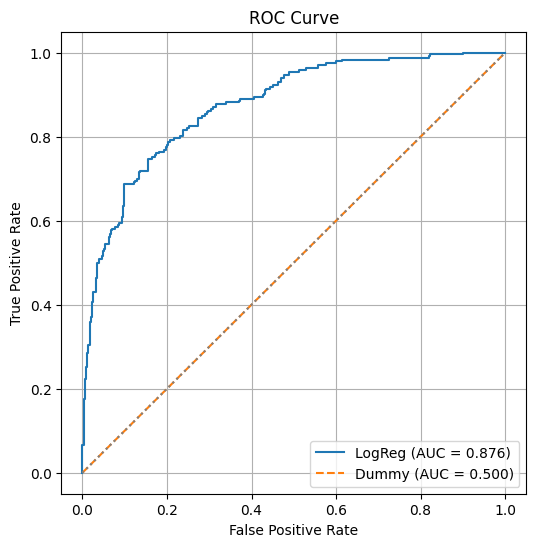

ROC figure saved to figures\roc_curve.png


In [6]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc:.3f})')
# dummy ROC
if y_proba_dummy is not None:
    try:
        fpr_d, tpr_d, _ = roc_curve(y_test, y_proba_dummy)
        auc_d = auc(fpr_d, tpr_d)
        plt.plot(fpr_d, tpr_d, label=f'Dummy (AUC = {auc_d:.3f})', linestyle='--')
    except Exception:
        pass

plt.plot([0, 1], [0, 1], color='grey', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
roc_path = FIG_DIR / 'roc_curve.png'
plt.savefig(roc_path, dpi=150)
plt.show()
print(f"ROC figure saved to {roc_path}")

## Сравнение моделей

In [7]:
results = pd.DataFrame([
    {
        'model': 'Dummy(most_frequent)',
        'accuracy': metrics_dummy['accuracy'],
        'roc_auc': metrics_dummy['roc_auc'],
    },
    {
        'model': 'LogisticRegression',
        'accuracy': metrics_logreg['accuracy'],
        'roc_auc': metrics_logreg['roc_auc'],
    }
])

print('\nComparison:')
print(results)

# Сохраняем таблицу
results.to_csv('figures/model_comparison.csv', index=False)



Comparison:
                  model  accuracy   roc_auc
0  Dummy(most_frequent)      0.59  0.500000
1    LogisticRegression      0.80  0.875637


## Краткие выводы

In [13]:
print('\nКраткие выводы:')
print('- Базовая модель (Dummy) задаёт минимальный порог, которого должна достигать наша модель.')
print('- Логистическая регрессия превосходит базовую модель, так как значения accuracy/ROC-AUC выше.')
print('- Лучшие параметры С', gs.best_params_)

import joblib
joblib.dump(best_model, 'figures/best_logreg_pipeline.joblib')
print('\nЛучшая модель сохранена в файл figures/best_logreg_pipeline.joblib')


Краткие выводы:
- Базовая модель (Dummy) задаёт минимальный порог, которого должна достигать наша модель.
- Логистическая регрессия превосходит базовую модель, так как значения accuracy/ROC-AUC выше.
- Лучшие параметры С {'logreg__C': 10.0}

Лучшая модель сохранена в файл figures/best_logreg_pipeline.joblib
